In [2]:
#import necessary libraries

import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## Train the model

In [3]:
#get dataset uri
trainx_data_uri = "s3://modeldata1234567/train/trainX.parquet"
trainy_data_uri = "s3://modeldata1234567/train/trainY.parquet"
testx_data_uri = "s3://modeldata1234567/test/testX.parquet"
testy_data_uri = "s3://modeldata1234567/test/testY.parquet"

In [4]:
session = sagemaker.Session()
role=get_execution_role()

In [5]:
# Define hyperparameters
hyperparameters = {
    "epochs": 1,
    "learning-rate": 0.001,
    "per-device-train-batch-size": 32,
    "per-device-test-batch-size": 32,
}

In [6]:
# Define parameters for the tensorflow framework
PYTHON_VERSION = "py39"
TENSORFLOW_VERSION = "2.10"


estimator = TensorFlow(
    py_version=PYTHON_VERSION,
    entry_point="train.py",
    framework_version=TENSORFLOW_VERSION,
    hyperparameters=hyperparameters,
    instance_type="ml.p2.xlarge",
    instance_count=1,
    role=role,
    debugger_hook_config=False,
    disable_profiler=True,
)

In [11]:
# Fit the model
estimator.fit({
    "trainx":trainx_data_uri,
    "trainy":trainy_data_uri,
    "testx":testx_data_uri,
    "testy":testy_data_uri
})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2024-07-24-19-57-41-281


2024-07-24 19:57:41 Starting - Starting the training job...
2024-07-24 19:58:07 Starting - Preparing the instances for training......
2024-07-24 19:58:51 Downloading - Downloading input data...
2024-07-24 19:59:22 Downloading - Downloading the training image.....................
2024-07-24 20:03:14 Training - Training image download completed. Training in progress...2024-07-24 20:03:25.560343: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-07-24 20:03:25.560574: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-07-24 20:03:25.600291: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 20:03:25.609648: W tensorflow/core/profiler/internal/smprofiler_timeline.c

## Deploy the model

In [15]:
# Create model from estimator
model = estimator.create_model(role=role, entry_point="inference_script.py")

# Deploy model
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge"
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-training-2024-07-24-20-21-06-562
INFO:sagemaker:Creating endpoint-config with name tensorflow-training-2024-07-24-20-21-14-105
INFO:sagemaker:Creating endpoint with name tensorflow-training-2024-07-24-20-21-14-105


-----!

## Test Deployed Model

In [16]:
# Load input data
local_file_path1 = "data/testX.parquet"
local_file_path2 = "data/testY.parquet"

input_data = pd.read_parquet(local_file_path1)
input_data = input_data.to_numpy().reshape(-1, 64, 64, 3)

actual_labels = pd.read_parquet(local_file_path2)
actual_labels = actual_labels['label'].to_numpy()

In [17]:
def visualize_image(image):
    """
    Visualizes a single image.
    Args:
        image (numpy.ndarray): The image data as a NumPy array.
    """
    plt.figure(figsize=(4, 4))  # Adjust the figure size as needed
    plt.imshow(image)
    plt.axis('off')
    plt.show()

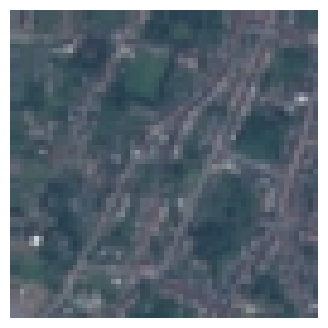

Prediction for image 0: Predicted class = 7, Actual class = 7


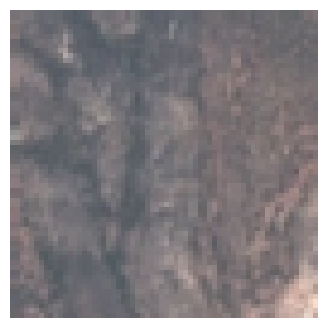

Prediction for image 1: Predicted class = 2, Actual class = 2


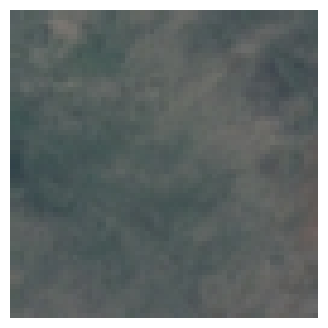

Prediction for image 2: Predicted class = 2, Actual class = 2


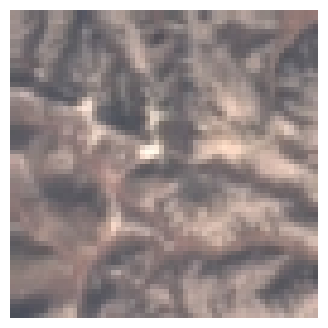

Prediction for image 3: Predicted class = 6, Actual class = 2


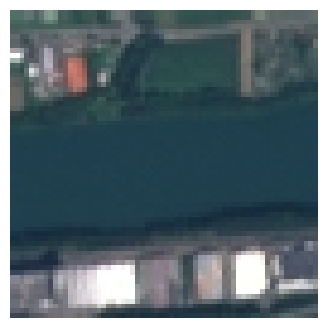

Prediction for image 4: Predicted class = 4, Actual class = 8


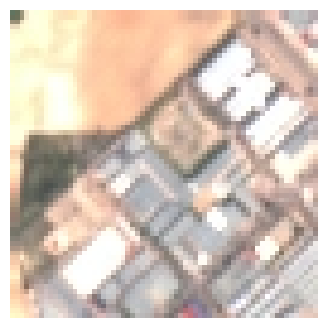

Prediction for image 5: Predicted class = 4, Actual class = 4


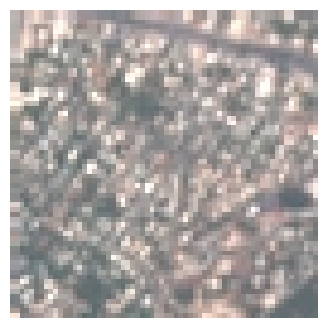

Prediction for image 6: Predicted class = 7, Actual class = 7


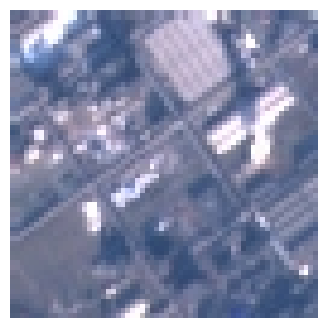

Prediction for image 7: Predicted class = 4, Actual class = 4


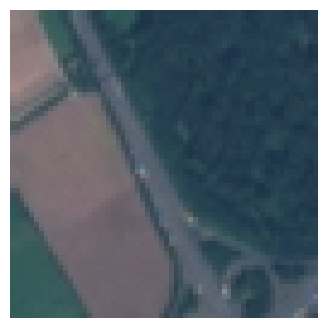

Prediction for image 8: Predicted class = 0, Actual class = 3


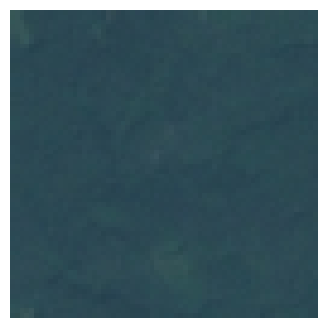

Prediction for image 9: Predicted class = 1, Actual class = 1


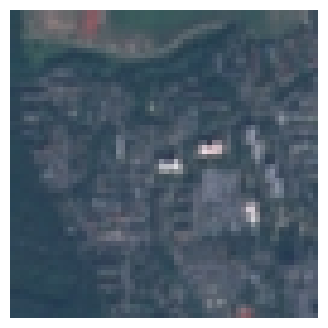

Prediction for image 10: Predicted class = 7, Actual class = 7


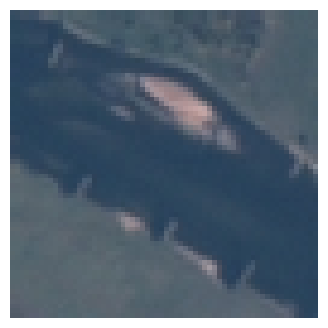

Prediction for image 11: Predicted class = 8, Actual class = 8


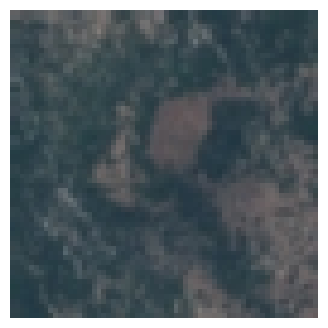

Prediction for image 12: Predicted class = 2, Actual class = 2


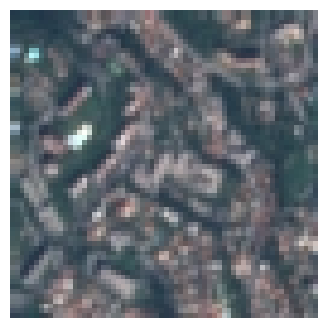

Prediction for image 13: Predicted class = 7, Actual class = 7


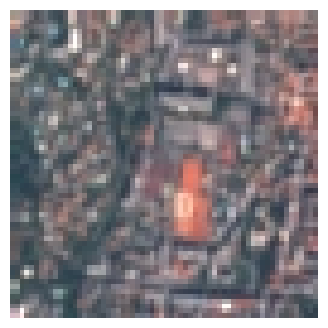

Prediction for image 14: Predicted class = 7, Actual class = 7


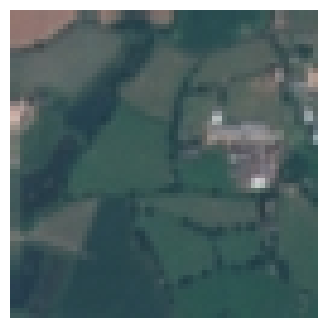

Prediction for image 15: Predicted class = 7, Actual class = 5


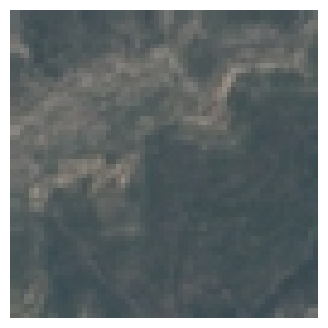

Prediction for image 16: Predicted class = 2, Actual class = 2


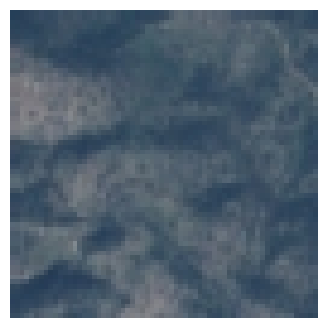

Prediction for image 17: Predicted class = 2, Actual class = 2


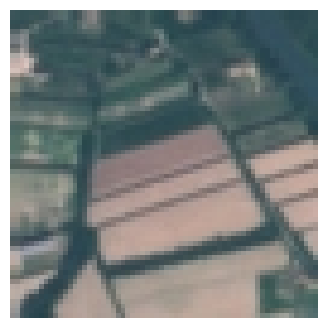

Prediction for image 18: Predicted class = 6, Actual class = 6


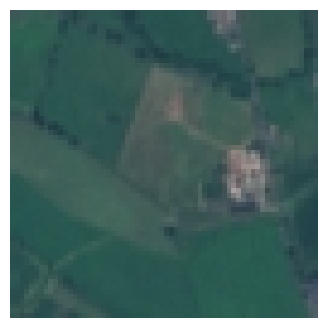

Prediction for image 19: Predicted class = 5, Actual class = 5


In [20]:
for i, img in enumerate(input_data):
    if i == 20:
        break
    batched_image = np.expand_dims(img, axis=0)
    batched_image_list = batched_image.tolist()
    prediction = predictor.predict(batched_image_list) #passing the test data to the deployed model. 
    predicted_probabilities = prediction['predictions'][0]
    predicted_class = np.argmax(predicted_probabilities)
    actual_class = actual_labels[i]  
    visualize_image(input_data[i])

    print(f"Prediction for image {i}: Predicted class = {predicted_class}, Actual class = {actual_class}")

## Delete endpoint

In [21]:
predictor.delete_endpoint(delete_endpoint_config=True)
model.delete_model()

INFO:sagemaker:Deleting endpoint configuration with name: tensorflow-training-2024-07-24-20-21-14-105
INFO:sagemaker:Deleting endpoint with name: tensorflow-training-2024-07-24-20-21-14-105
INFO:sagemaker:Deleting model with name: tensorflow-training-2024-07-24-20-21-06-562
